In [1]:
import os
from PIL import Image
import yaml
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import datasets
import models
import utils
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

c:\Users\anees\Documents\MSCS\CSE252D\venv\Lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
CONFIG_PATH = os.path.join(os.getcwd(), "configs", "cod-sam-vit-h.yaml")
MODEL_CHECKPOINT = os.path.join(os.getcwd(), "pretrained/best_results/cod/model_epoch_best.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(CONFIG_PATH, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = models.make(config['model'])
model.to(device)
sam_checkpoint = torch.load(MODEL_CHECKPOINT, map_location='cuda:0')
model.load_state_dict(sam_checkpoint, strict=True)
model.eval()

SAM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [3]:
def process_image(img):
    preprocess = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        masks = model.infer(input_tensor)

    # Resize mask to input image size
    mask = torch.sigmoid(masks[0, 0])
    mask_np = (mask.cpu().numpy() * 255).astype('uint8')
    orig_w, orig_h = img.size
    y_idx = np.round(np.linspace(0, 1023, orig_h)).astype(int).clip(0, 1023)
    x_idx = np.round(np.linspace(0, 1023, orig_w)).astype(int).clip(0, 1023)
    resized_mask = mask_np[y_idx[:, None], x_idx]
   
    overlay = np.zeros((orig_h, orig_w, 4), dtype=np.uint8)  # (H, W, RGBA)
    overlay[resized_mask > 100] = [255, 0, 0, 160]  # Apply threshold and color

    overlaid_image = Image.alpha_composite(
        img.convert('RGBA'), 
        Image.fromarray(overlay, 'RGBA')
    )
    # Composite images
    return Image.alpha_composite(
        img.convert('RGBA'), 
        Image.fromarray(overlay, 'RGBA')
    ), resized_mask

In [4]:
# Plot image
def plot_image(original_image, mask, processed_image):
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)  
    plt.axis("off") 
    plt.title("Original Image") 
    plt.subplot(1, 3, 2)
    plt.imshow(mask)  
    plt.axis("off") 
    plt.title("Mask") 
    plt.subplot(1, 3, 3)
    plt.imshow(processed_image)  
    plt.axis("off") 
    plt.title("Segmented Image") 
    plt.show()

In [5]:
# Read and process image
camouflage_img_path = os.path.join(os.getcwd(), "load/COD10K-CAM-1-Aquatic-7-Flounder-253.jpg")
camouflage_img = Image.open(camouflage_img_path).convert('RGB')
camouflage_processed_img, camouflage_mask = process_image(camouflage_img)

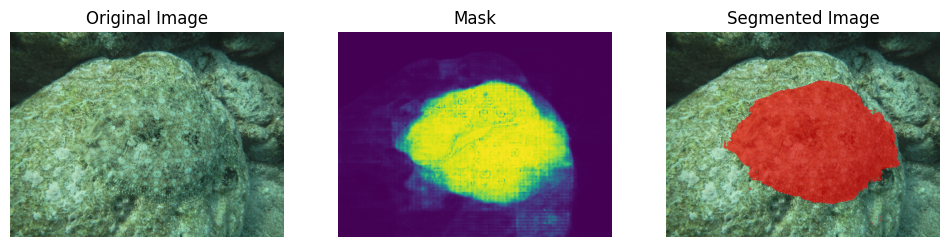

In [6]:
plot_image(camouflage_img, camouflage_mask, camouflage_processed_img)

In [7]:
MODEL_CHECKPOINT = os.path.join(os.getcwd(), "pretrained/best_results/istd/model_epoch_best.pth")
sam_checkpoint = torch.load(MODEL_CHECKPOINT, map_location='cuda:0')
model.load_state_dict(sam_checkpoint, strict=True)
model.eval()

SAM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
# Read and process image
shadow_img_path = os.path.join(os.getcwd(), "load/ISTD_Dataset/ISTD_Dataset/test/test_A/106-1.png")
shadow_img = Image.open(shadow_img_path).convert('RGB')
shadow_processed_img, shadow_mask = process_image(shadow_img)

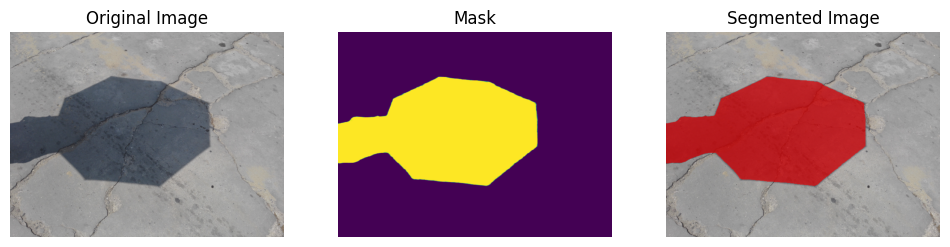

In [9]:
plot_image(shadow_img, shadow_mask, shadow_processed_img)

In [10]:
# Read and process image
polyp_img_path = os.path.join(os.getcwd(), "load/Kvasir-SEG/images/cju2nd7l7z98o0799gfjvyfmw.jpg")
polyp_img = Image.open(polyp_img_path).convert('RGB')
polyp_processed_img, polyp_mask = process_image(polyp_img)

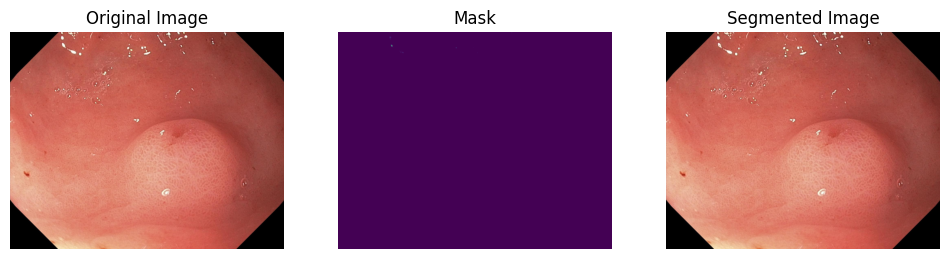

In [12]:
plot_image(polyp_img, polyp_mask, polyp_processed_img)